# 基于Mindspore实现推荐系统

## 实验内容

实现一个电影推荐系统，评价指标为CTR(Click-Through-Rate)预估：即对点击率的估计。

通过将数据集转为one-hot编码实现特征提取，使用逻辑回归实现CTR预估

## 基于逻辑回归的推荐系统

Logistic regression 公式：$$y'=w_0+\sum_{i}^{n}w_i*x_i$$
$$y=sigmoid(y')=\frac{1}{1+e^{-y'}}$$

原始数据为：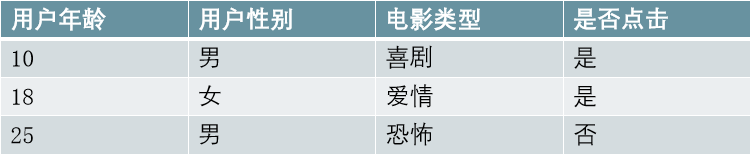

经过one-hot编码后为：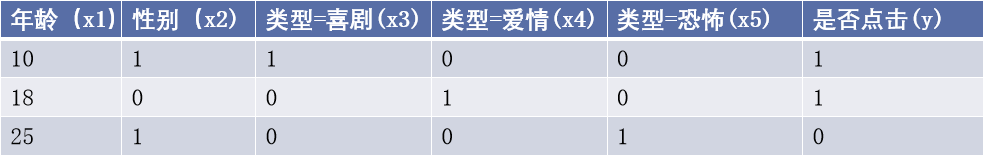


以预测第一行特征的点击率为例：

$$X=[10,1,1,0,0,1]$$
$$W=[w_1,w_2,w_3,w_4,w_5]$$
$$Y=sigmoid(dot(W,X)+W_0)$$

### Mindspore实现逻辑回归

在mindspore中可以使用Dense层实现逻辑回归中向量计算部分，$$output=activation(X*kernel+bias)$$激活函数选择sigmoid即可。

## 环境信息

使用Mindspore1.8.0 安装方式参考https://www.mindspore.cn/

## 数据集分析

#### 数据集下载地址为https://grouplens.org/datasets/movielens/100k/

实验用到的数据集为：
1. ua.base 和 ua.test: 训练集和测试集，包括用户id,作品id,评分。我们将获得三分以上评分的作品视为用户已点击
2. u.user: 用户特征数据，包括用户id,用户年龄，性别，职业。需要将用户特征进行one-hot编码实现
3. u.item: 电影特征数据，已将电影特征处理为one-hot编码。
4. u.occupation: 用户职业类别，作为ont-hot编码用。

## 实验代码

In [1]:

'''
数据集one-hot编码处理
'''
import os
import numpy as np

base_path='data/ml-100k'
train_path = os.path.join(base_path,'ua.base')
test_path = os.path.join(base_path,'ua.test')
user_path = os.path.join(base_path,'u.user')
item_path = os.path.join(base_path,'u.item')
occupation_path = os.path.join(base_path,'u.occupation')


def get1or0(r):
    return 1.0 if r>3 else 0.0

def __read_rating_data(path):
    dataSet={}
    with open(path,'r') as f:
        for line in f.readlines():
            d=line.strip().split('\t')
            dataSet[(int(d[0]),int(d[1]))]=[get1or0(int(d[2]))]
    return dataSet

def __read_item_hot():
    items={}
    with open(item_path,'r',encoding='ISO-8859-1') as f:
        for line in f.readlines():
            d=line.strip().split('|')
            items[int(d[0])]=np.array(d[5:],dtype='float64')
    return items


def __read_occupation_hot():
    occupations = {}
    with open(occupation_path,'r') as f:
        names=f.read().strip().split('\n')
    length=len(names)
    for i in range(length):
        l=np.zeros(length,dtype='float64')
        l[i]=1
        occupations[names[i]]=l
    return occupations

def __read_user_hot():
    users={}
    gender_dict={'M':1,'F':0}
    occupation_dict = __read_occupation_hot()
    with open(user_path,'r') as f:
        for line in f.readlines():
            d=line.strip().split('|')
            a=np.array([int(d[1]), gender_dict[d[2]]])
            users[int(d[0])]=np.append(a,occupation_dict[d[3]])
    return users

def read_dataSet(user_dict,item_dict,path):
    X, Y = [], []
    ratings = __read_rating_data(path)
    for k in ratings:
        X.append(np.append(user_dict[k[0]], item_dict[k[1]]))
        Y.append(ratings[k])
    return X,Y


def read_data():
    user_dict = __read_user_hot()
    item_dict=__read_item_hot()
    trainX,trainY=read_dataSet(user_dict,item_dict,train_path)
    testX,testY=read_dataSet(user_dict,item_dict,test_path)

    return trainX,trainY,testX,testY



In [ ]:
from mindspore import Tensor, ops
from mindspore import dtype as mstype
import mindspore as ms
from mindspore import dataset as ds
from mindspore.common.initializer import Normal
from mindspore import LossMonitor
import numpy as np
import mindspore.nn as nn
import mindspore as ms
import mindspore.ops as ops
from mindspore.train import Model

epochs = 10
batch_size = 32
learning_rate = 1e-2

'''
进行mindspore网络所需数据处理
'''
# 获取训练集或测试集数据
def get_data(trian=True):

    trainX, trainY, testX, testY= read_data()
    train_size=len(trainX)
    test_size=len(testX)
    if trian == True:
        for i in range(train_size):
            y = trainY[i]
            x = trainX[i]
            yield np.array(x[:]).astype(np.float32), np.array([y[0]]).astype(np.float32)
    else:
        for i in range(test_size):
            y = testY[i]
            x = testX[i]
            yield np.array(x[:]).astype(np.float32), np.array([y[:]]).astype(np.float32)
            
# 将数据处理为mindspore格式 使用GeneratorDataset创建可迭代数据
def create_dataset(batch_size=32, repeat_size=1, train=True):
    """定义数据集"""
    input_data = ds.GeneratorDataset(list(get_data( train)), column_names=['data', 'label'])
    input_data = input_data.batch(batch_size)
    input_data = input_data.repeat(repeat_size)
    return input_data

# 逻辑回归，可直接使用一层Dense实现，也可增加层数
class Network(nn.Cell):
    def __init__(self):
        super(Network, self).__init__()
        self.fc1 = nn.Dense(42, 21, Normal(0.02), Normal(0.02))
        self.fc2 = nn.Dense(21, 1, Normal(0.02), Normal(0.02))
        self.relu=nn.ReLU()
        self.sigmoid=nn.Sigmoid()
    def construct(self, x):
        x=self.fc1(x)
        x=self.relu(x)
        x=self.fc2(x)
        x=self.sigmoid(x)
        return x


# 创建训练集和测试机 默认batch_size=32    
train_dataset = create_dataset(batch_size)
test_dataset = create_dataset(batch_size,train=False)

# 创建网络 并查看网络结构
net=Network()
print(net)

# 初始化loss 优化器
loss_fn = nn.BCEWithLogitsLoss(reduction="mean")
optimizer = nn.Momentum(net.trainable_params(),learning_rate=learning_rate,momentum=0.1)

# 模型训练
model=Model(net,loss_fn=loss_fn,optimizer=optimizer,metrics={"acc"})
model.train(epochs,train_dataset,callbacks=[LossMonitor()])

# 模型保存
ms.save_checkpoint(net,"./MyNet.ckpt")

# 输出预测值和真实值
for data,label in test_dataset:
    pre = model.predict(data)
    print(f"pre---{pre}")
    print(f"label---{label}")


Network<
  (fc1): Dense<input_channels=42, output_channels=21, has_bias=True>
  (fc2): Dense<input_channels=21, output_channels=1, has_bias=True>
  (relu): ReLU<>
  (sigmoid): Sigmoid<>
  >
epoch: 1 step: 2831, loss is 0.6809984445571899
epoch: 2 step: 2831, loss is 0.7313994765281677
epoch: 3 step: 2831, loss is 0.6791567802429199
epoch: 4 step: 2831, loss is 0.6946772336959839
epoch: 5 step: 2831, loss is 0.672170877456665
epoch: 6 step: 2831, loss is 0.7075434923171997
epoch: 7 step: 2831, loss is 0.7226353883743286
epoch: 8 step: 2831, loss is 0.6696066856384277
epoch: 9 step: 2831, loss is 0.7209290266036987
epoch: 10 step: 2831, loss is 0.6782121658325195
pre---[[0.22464961]
 [0.21909569]
 [0.28851762]
 [0.26157808]
 [0.21130131]
 [0.24884805]
 [0.24049327]
 [0.24599259]
 [0.19586293]
 [0.2608643 ]
 [0.25710103]
 [0.17925487]
 [0.24291767]
 [0.25668526]
 [0.3213418 ]
 [0.23600444]
 [0.21963513]
 [0.23317897]
 [0.25404024]
 [0.31764087]
 [0.2556474 ]
 [0.27273816]
 [0.27352256]
 [